In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn.functional import relu
from scipy.io import loadmat
import os
from os import listdir
import pandas as pd
from skimage import io
from PIL import Image
from scipy.io import loadmat


In [2]:
torch.tensor([1])

tensor([1])

In [3]:
pwd

'/mnt/pesaranlab/People/Capstone_students/Noah/Sleeping-Monkeys/notebooks'

In [4]:
cd ../../../Noah

/mnt/pesaranlab/People/Capstone_students/Noah


In [5]:
moving_files = os.listdir('data2/move/')
sleeping_files = os.listdir('data2/sleep')

In [6]:
class NoahSpectrogramDataset(Dataset):
    def __init__(self, mode='train' ,moving_files=moving_files,sleeping_files=sleeping_files):
        self.movement_files = moving_files
        self.sleeping_files = sleeping_files
        all_files = self.sleeping_files + self.movement_files
        if mode == 'train':
            self.all_files = [f for f in all_files if f.split('_')[0] not in ['180330','180331','180410','180411','180412', '180413']]
        elif mode == 'valid':
            self.all_files = [f for f in all_files if f.split('_')[0] in ['180330','180331','180410','180411','180412', '180413']]

            
        # clean
    def __len__(self):
        return len(self.all_files)
    
    def __getitem__(self, idx):
       # labe
       # spec = torch.from_numpy(np.load('data/'self.all_files[idx])).unsqueeze(0)
        mvmt_type  = self.all_files[idx].split('_')[-1].split('.')[0] #check this out
        date = self.all_files[idx].split('_')[0]
        rec = self.all_files[idx].split('_')[1].split('_')[0]
        spec = torch.from_numpy(np.load('data/'+ mvmt_type +'/' +self.all_files[idx])) 
        if mvmt_type == 'move':
            label = torch.Tensor([0])
        elif mvmt_type == 'sleep':
            label = torch.Tensor([1])
        else:
            label = torch.Tensor([-1])
        return  torch.transpose(spec,1,2) , label, date, rec

In [7]:
train_dataset = NoahSpectrogramDataset(mode='train')
valid_dataset = NoahSpectrogramDataset(mode='valid')


In [8]:
targets = [int(train_dataset.__getitem__(i)[1].item()) for i in range(train_dataset.__len__())]


In [10]:
class_sample_count = np.unique(targets, return_counts=True)[1]


In [35]:
torch.from_numpy(weight).float()

tensor([0.0011, 0.0002])

In [11]:
weight = 1. / class_sample_count
samples_weight = weight[targets]
samples_weight = torch.from_numpy(samples_weight)

In [12]:
train_loader = DataLoader(dataset = train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(dataset = valid_dataset, batch_size = 32, shuffle = False)

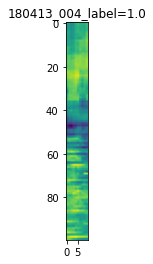

In [13]:
for spec, label, date, rec in val_loader:
    plt.figure()
    plt.title(date[0] + "_" + rec[0] + "_label=" +str(label[0].item()))
    plt.imshow(spec[0][:].mean(axis=0))
    break
    

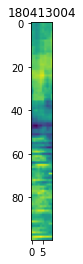

In [14]:
plt.title(date[0] + rec[0])
plt.imshow(spec[0][:].mean(axis=0))

In [15]:
class CNN(nn.Module):
    def __init__(self, in_channels = 1, num_classes = 1):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.dropout1 = nn.Dropout2d(.5)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.fc1 = nn.Linear(8*100*10, num_classes)
        self.dropout2 = nn.Dropout2d(.5)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = x.float()
        x = self.dropout1(relu(self.conv1(x)))
        x = self.dropout2(relu(self.conv2(x)))
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x).flatten()
        x = self.sigmoid(x)
        return x
    
class LogReg(nn.Module):
    def __init__(self, input_dim=100*10, output_dim=1):
        super(LogReg, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.resize(x.shape[0],1,10*100).float()
        outputs = torch.sigmoid(self.linear(x))
        return outputs
    
class MLP(nn.Module):
    def __init__(self, num_classes = 1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(100*10, 200)
        self.fc2 = nn.Linear(200, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, verbose=True):
        x = x.float().reshape(x.shape[0], -1)
        x = relu(self.fc1(x))
        x = relu(self.fc2(x)).flatten()
        x = self.sigmoid(x)
        return x

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 1000 #(10x100)
num_classes = 1
learning_rate = 0.001
num_epochs = 10

model = LogReg().to(device)
criterion = nn.BCELoss()#weight=torch.from_numpy(weight).float())
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [49]:
def get_accuracy(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels, night, rec = data
            images = images.mean(axis=1)
            outputs = model(images)
            predictions = []
            for o in outputs:
                if o.item() > .5:
                    predictions.append(1)
                else:
                    predictions.append(0)
            predictions = np.array(predictions)
            total += labels.size(0)
            correct += (predictions.flatten() == labels.flatten().numpy()).sum().item()
    return correct / total

In [50]:
def train(epoch):
    model.train()
    batch_losses = []
    
    for batch_idx, (data, labels, date, rec) in enumerate(train_loader):
        
        data = data.to(device)
        data = data.mean(axis=1)
        labels = labels.to(device).float()
        
        
        preds = model(data)
        loss = criterion(preds, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss)
        
    epoch_loss = sum(batch_losses)/len(batch_losses)
    acc = get_accuracy(train_loader) 
    return epoch_loss,acc

def test(loader):
    model.eval()
    batch_losses = []
    
    with torch.no_grad():
        for batch_idx, (data, labels, date, rec) in enumerate(loader):
            data = data.to(device)
            data = data.mean(axis=1)
            labels = labels.to(device).float()
            
            if (torch.isinf(data).any()) or (torch.isnan(data).any()):
                print('NaN in test?')
                continue
            
            preds = model(data)
            loss = criterion(preds, labels)
            
            batch_losses.append(loss)
        
        epoch_loss = sum(batch_losses)/len(batch_losses)
        
    acc = get_accuracy(loader)
    return epoch_loss,acc

In [51]:
epochs = []
training_losses = []
training_acc = []
val_losses = []
validation_acc = []

for epoch in range(num_epochs):
    avg_train_loss, train_acc = train(epoch)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss, val_acc = test(val_loader)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    epochs.append(epoch)
    training_losses.append(avg_train_loss)
    training_acc.append(train_acc)
    val_losses.append(val_loss)
    validation_acc.append(val_acc)

KeyboardInterrupt: 

In [32]:
%debug

> /home/bijanadmin/anaconda3/envs/monkey/lib/python3.8/site-packages/torch/nn/functional.py(2483)binary_cross_entropy()
   2481         weight = weight.expand(new_size)
   2482 
-> 2483     return torch._C._nn.binary_cross_entropy(
   2484         input, target, weight, reduction_enum)
   2485 

ipdb> u
> /home/bijanadmin/anaconda3/envs/monkey/lib/python3.8/site-packages/torch/nn/modules/loss.py(529)forward()
    527 
    528     def forward(self, input: Tensor, target: Tensor) -> Tensor:
--> 529         return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
    530 
    531 

ipdb> exit


In [ ]:
plt.style.use('dark_background')


In [ ]:
plt.figure()
plt.title("Log Reg", fontsize = 15)
plt.plot(training_acc,linewidth = 1.5,label = 'train')
plt.plot(validation_acc,linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend()

plt.figure()
plt.title("Log Reg", fontsize = 15)
plt.plot(training_losses,linewidth = 1.5,label = 'train')
plt.plot(val_losses,linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.legend()

# Visualize Weights

In [ ]:
for param in model.parameters():
    print(param)
    break
    #break

In [ ]:
plt.imshow(param[0].reshape(100,10).detach().numpy())


In [ ]:
!pwd

In [ ]:
f = os.listdir('data/sleep')[0]

In [ ]:
f.split('_')[:2]

In [ ]:
spec_f = []
for f in os.listdir('data/sleep'):
    night, rec = f.split('_')[:2]
    night_rec = night + "_" + rec
    spec_f.append(night_rec)

In [ ]:
spec_f

In [ ]:
 '180410_002' in list(set(spec_f))

In [ ]:
# Examining one not used here.


spec_data = loadmat('../Spectrogram_mat_data/N10W1dn1_180331_rec002.mat')

In [ ]:
goose_files = []
for f in os.listdir('../Spectrogram_mat_data/'):
    if 'N10W1dn1' in f:
        goose_files.append(f)

In [ ]:
for gf in goose_files: #these are files that are spectrograms, but are not saved by us. 
    if gf not in list(set(spec_f)):
        print(gf)
        try:
            spec_data = loadmat('../Spectrogram_mat_data/' + gf)

            all_badtimes = np.array([])
            specs = []
            for ch in range(1,63): #iterate over the 62 channels saved, stack together and proceed with that. 
                ztotSpec = spec_data['Spec_per_Ch']['Ch'+str(ch)][0][0]['ztotSpec'][0][0]
                # TODO: NaN check 
                specs.append(ztotSpec)

                badtimes = spec_data['Spec_per_Ch']['Ch'+str(ch)][0][0]['badtimes'][0][0]
                all_badtimes = np.concatenate([all_badtimes, badtimes.flatten()])
            all_badtimes = np.array(list(set(all_badtimes))) #method 1 
            ztotSpecs = np.stack(specs) # 62 x 100 x 7000
            print(np.isnan(ztotSpecs).sum())
        except Exception as e:
            print(e)

In [ ]:
spec_data = loadmat('../Spectrogram_mat_data/N10W1dn1_180410_rec002.mat')

In [ ]:
spec_data

In [ ]:

all_badtimes = np.array([])
specs = []
for ch in range(1,63): #iterate over the 62 channels saved, stack together and proceed with that. 
    ztotSpec = spec_data['Spec_per_Ch']['Ch'+str(ch)][0][0]['ztotSpec'][0][0]
    # TODO: NaN check 
    specs.append(ztotSpec)
    print(ztotSpec)
    badtimes = spec_data['Spec_per_Ch']['Ch'+str(ch)][0][0]['badtimes'][0][0]
    all_badtimes = np.concatenate([all_badtimes, badtimes.flatten()])

all_badtimes = np.array(list(set(all_badtimes))) #method 1 
ztotSpecs = np.stack(specs) # 62 x 100 x 7000


In [ ]:
spec_data['Spec_per_Ch']['Ch1'][0][0]['m_start']